DBSCAN Metrics:
DBSCAN produced only one cluster.
DBSCAN produced only one cluster.
DBSCAN produced only one cluster.

KMeans Metrics:
Davies-Bouldin Index: 1.2476
Silhouette Score: 0.3401
Calinski-Harabasz Index: 55.5707

GMM Metrics:
Davies-Bouldin Index: 1.1433
Silhouette Score: 0.3598
Calinski-Harabasz Index: 53.8772


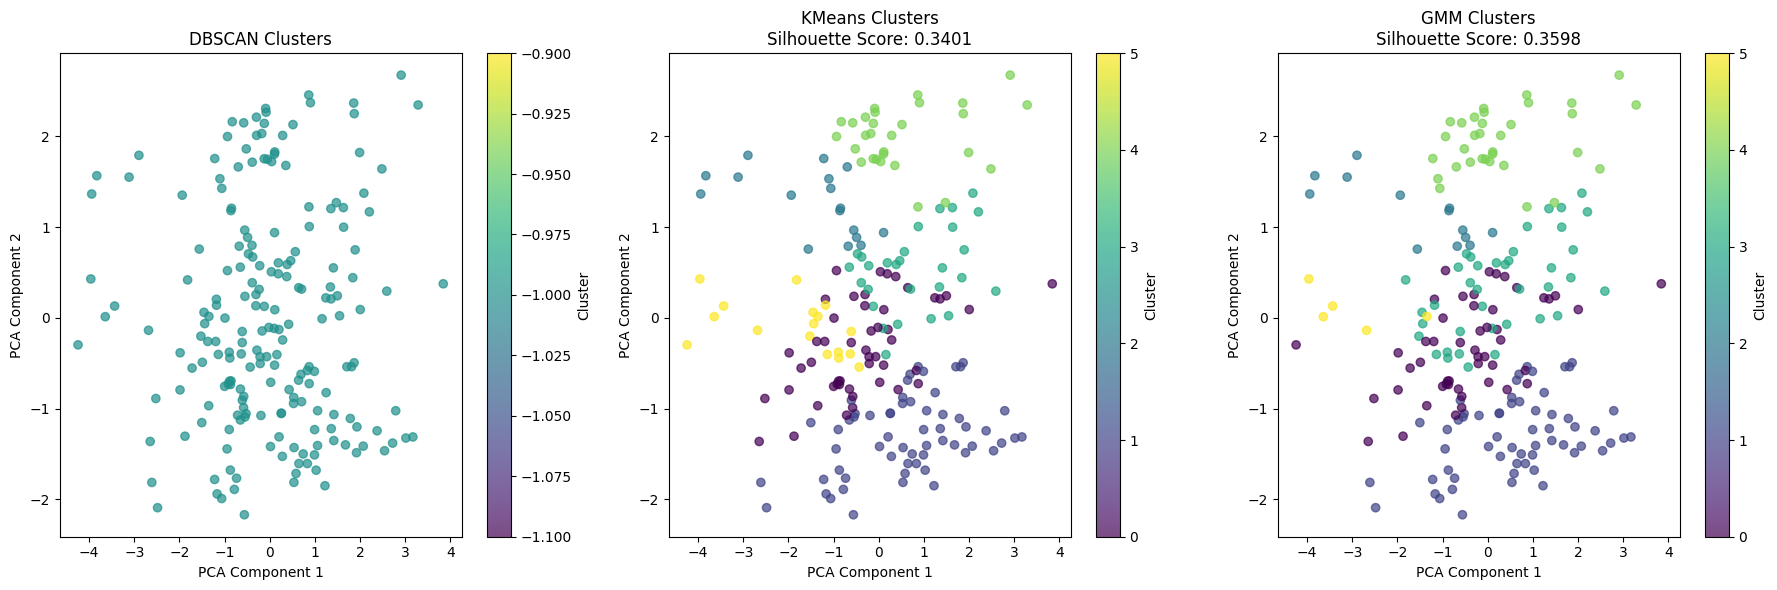

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

rfm = transactions.groupby('CustomerID').agg(
    Frequency=('TransactionID', 'count'),
    Recency=('TransactionDate', lambda x: (pd.to_datetime('now') - pd.to_datetime(x).max()).days),
    Monetary=('TotalValue', 'sum')
).reset_index()

data = pd.merge(customers, rfm, on='CustomerID')


data['Tenure'] = (pd.to_datetime('now') - pd.to_datetime(data['SignupDate'])).dt.days
data = pd.get_dummies(data, columns=['Region']).drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)
data = data.fillna(data.mean())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_data)

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_data)

gmm = GaussianMixture(n_components=6, random_state=42)
gmm_clusters = gmm.fit_predict(scaled_data)

def evaluate_clustering(data, clusters):
    if len(np.unique(clusters)) > 1:
        db_index = davies_bouldin_score(data, clusters)
        silhouette = silhouette_score(data, clusters)
        calinski = calinski_harabasz_score(data, clusters)
        return db_index, silhouette, calinski
    else:
        return None, None, None

dbscan_db, dbscan_silhouette, dbscan_calinski = evaluate_clustering(scaled_data, dbscan_clusters)

kmeans_db, kmeans_silhouette, kmeans_calinski = evaluate_clustering(scaled_data, kmeans_clusters)

gmm_db, gmm_silhouette, gmm_calinski = evaluate_clustering(scaled_data, gmm_clusters)

print("DBSCAN Metrics:")
print(f"Davies-Bouldin Index: {dbscan_db:.4f}" if dbscan_db else "DBSCAN produced only one cluster.")
print(f"Silhouette Score: {dbscan_silhouette:.4f}" if dbscan_silhouette else "DBSCAN produced only one cluster.")
print(f"Calinski-Harabasz Index: {dbscan_calinski:.4f}" if dbscan_calinski else "DBSCAN produced only one cluster.")
print()

print("KMeans Metrics:")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Calinski-Harabasz Index: {kmeans_calinski:.4f}")
print()

print("GMM Metrics:")
print(f"Davies-Bouldin Index: {gmm_db:.4f}")
print(f"Silhouette Score: {gmm_silhouette:.4f}")
print(f"Calinski-Harabasz Index: {gmm_calinski:.4f}")

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_clusters, cmap='viridis', alpha=0.7)
plt.title(f'DBSCAN Clusters\nSilhouette Score: {dbscan_silhouette:.4f}' if dbscan_silhouette else 'DBSCAN Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')

plt.subplot(1, 3, 2)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_clusters, cmap='viridis', alpha=0.7)
plt.title(f'KMeans Clusters\nSilhouette Score: {kmeans_silhouette:.4f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')

plt.subplot(1, 3, 3)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=gmm_clusters, cmap='viridis', alpha=0.7)
plt.title(f'GMM Clusters\nSilhouette Score: {gmm_silhouette:.4f}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()